### GPT의 주요 변경점 (Transformer와 비교)

1. Transformer에서 디코더 부분만 사용 (Decoder-Only)
2. Transformer는 supervised learning이었으나     
GPT1은 Semi-supervised learning (unsupervised pre-training, supervised fine-tuning) 
3. Dataset을 변경해야함

In [1]:
import tensorflow as tf
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

2024-12-04 05:41:43.207556: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-04 05:41:43.226012: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-04 05:41:43.226031: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-04 05:41:43.226042: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-04 05:41:43.229789: I tensorflow/core/platform/cpu_feature_g

데이터 불러오기

In [2]:
data = pd.read_csv('./data/ChatbotData.csv')

In [3]:
data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [4]:
data = data[['Q', 'A']]
data.head()

,Q,A
0,12시 땡!,하루가 또 가네요.
1,1지망 학교 떨어졌어,위로해 드립니다.
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.
4,PPL 심하네,눈살이 찌푸려지죠.


In [5]:
print('데이터 형상 : ', data.shape)
print('결측치 확인')
print(data.isna().sum())

데이터 형상 :  (11823, 2)
결측치 확인
Q    0
A    0
dtype: int64


전처리

In [6]:
# 데이터 전처리 함수 정의
def preprocess_text(text):
    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    # 예를 들어서 "I am a student." => "I am a student ."와 같이
    # student와 온점 사이에 거리를 만듭니다.
    text = re.sub(r"([?.!,])", r" \1 ", text)
    text = re.sub(r'[" "]+', " ", text)
    # 특수 문자 제거, 불필요한 공백 제거
    text = re.sub(r"[^가-힣a-zA-Z0-9\s.,!?]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

# 질문과 답변에 전처리 적용
data['Q'] = data['Q'].apply(preprocess_text)
data['A'] = data['A'].apply(preprocess_text)

data['combine'] = data['Q'] + ' ' + data['A']

# 전처리 결과 확인
for text in data['combine'][:5]:
    print(text)

12시 땡 ! 하루가 또 가네요 .
1지망 학교 떨어졌어 위로해 드립니다 .
3박4일 놀러가고 싶다 여행은 언제나 좋죠 .
3박4일 정도 놀러가고 싶다 여행은 언제나 좋죠 .
PPL 심하네 눈살이 찌푸려지죠 .


In [7]:
train = []
for text in data['combine']:
    train.append(preprocess_text(text))

임베딩

In [8]:
import tensorflow_datasets as tfds

# 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    train, target_vocab_size=2**13)
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
print('START_TOKEN의 번호 :', [tokenizer.vocab_size])
print('END_TOKEN의 번호 :' , [tokenizer.vocab_size + 1])
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

START_TOKEN의 번호 : [8354]
END_TOKEN의 번호 : [8355]
8356


In [9]:
# 임의의 10번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 10번째 질문 샘플: {}'.format(tokenizer.encode(train[9])))

정수 인코딩 후의 10번째 질문 샘플: [2150, 1153, 7770, 164, 84, 170, 436, 1256, 8130, 346, 4024, 15, 34, 1]


텍스트의 최소 길이 : 2
텍스트의 최대 길이 : 32
텍스트의 평균 길이 : 8.653049141503848


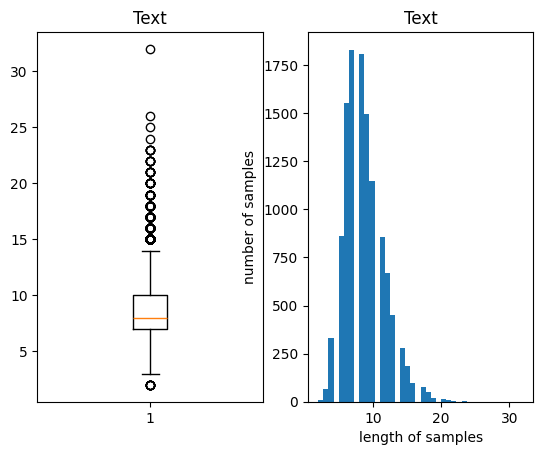

In [10]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in train]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [11]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
max_tokens = np.mean(text_len) + 2 * np.std(text_len) + 6
MAX_LENGTH = int(max_tokens)
print(MAX_LENGTH)

20


In [12]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if (len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s' % (max_len, (cnt / len(nested_list))))

In [13]:
below_threshold_len(MAX_LENGTH, train)

전체 샘플 중 길이가 20 이하인 샘플의 비율: 0.9980546392624545


In [14]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs):
    tokenized_inputs = []

    for sentence in inputs:
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence = START_TOKEN + tokenizer.encode(sentence) + END_TOKEN
        # 최대 길이 이하인 경우에만 데이터셋으로 허용
        if len(sentence) <= MAX_LENGTH:
            tokenized_inputs.append(sentence)

    # 최대 길이로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='post')

    return tokenized_inputs

In [15]:
train = tokenize_and_filter(train)
print('단어장의 크기 :', (VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(train)))

단어장의 크기 : 8356
필터링 후의 질문 샘플 개수: 11203


모델 정의

In [16]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding, MultiHeadAttention, LayerNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# 하이퍼파라미터
vocab_size = tokenizer.vocab_size  # 토크나이저 단어 집합 크기
embedding_dim = 128
num_heads = 8
ff_dim = 512
max_length = 128

# Transformer Block 정의
def transformer_block(inputs, num_heads, ff_dim, dropout_rate=0.1):
    attention = MultiHeadAttention(
        num_heads=num_heads, key_dim=embedding_dim)(inputs, inputs)
    attention = Dropout(dropout_rate)(attention)
    attention = LayerNormalization(epsilon=1e-6)(inputs + attention)

    ff_output = Dense(ff_dim, activation='relu')(attention)
    ff_output = Dense(embedding_dim)(ff_output)
    ff_output = Dropout(dropout_rate)(ff_output)
    return LayerNormalization(epsilon=1e-6)(attention + ff_output)

# GPT 모델 정의
def build_gpt(vocab_size, max_length, embedding_dim, num_heads, ff_dim):
    inputs = Input(shape=(None,))
    embeddings = Embedding(vocab_size, embedding_dim)(inputs)

    x = embeddings
    for _ in range(4):  # 4개의 Transformer 블록
        x = transformer_block(x, num_heads, ff_dim)

    outputs = Dense(vocab_size, activation="softmax")(x)
    return Model(inputs, outputs)


# 모델 생성 및 컴파일
model = build_gpt(vocab_size, max_length, embedding_dim, num_heads, ff_dim)
model.compile(optimizer=Adam(learning_rate=5e-5),
              loss="sparse_categorical_crossentropy", metrics=["accuracy"])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, None, 128)            1069312   ['input_1[0][0]']             
                                                                                                  
 multi_head_attention (Mult  (None, None, 128)            527488    ['embedding[0][0]',           
 iHeadAttention)                                                     'embedding[0][0]']           
                                                                                                  
 dropout (Dropout)           (None, None, 128)            0         ['multi_head_attention[0][

2024-12-04 05:41:48.379578: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-04 05:41:48.382076: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-04 05:41:48.382146: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [17]:
# 학습 데이터 준비
x_train = train[:, :-1]  # 입력 데이터
y_train = train[:, 1:]   # 출력 데이터

# 모델 학습
model.fit(
    x_train,
    y_train,
    batch_size=32,
    epochs=5,
    validation_split=0.2
)

Epoch 1/5


2024-12-04 05:41:51.277306: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f855ee29660 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-04 05:41:51.277320: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-12-04 05:41:51.279642: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-04 05:41:51.285797: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2024-12-04 05:41:51.327051: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


281/281 [==============================] - 9s 18ms/step - loss: nan - accuracy: 0.4000 - val_loss: nan - val_accuracy: 0.2889
Epoch 2/5
281/281 [==============================] - 3s 10ms/step - loss: nan - accuracy: 0.4015 - val_loss: nan - val_accuracy: 0.2889
Epoch 3/5
281/281 [==============================] - 3s 10ms/step - loss: nan - accuracy: 0.4015 - val_loss: nan - val_accuracy: 0.2889
Epoch 4/5
281/281 [==============================] - 2s 8ms/step - loss: nan - accuracy: 0.4015 - val_loss: nan - val_accuracy: 0.2889
Epoch 5/5
281/281 [==============================] - 2s 9ms/step - loss: nan - accuracy: 0.4015 - val_loss: nan - val_accuracy: 0.2889


In [18]:
def generate_response(input_text, model, tokenizer, max_length=128):
    # 입력 문장 인코딩 및 패딩
    input_seq = [START_TOKEN + tokenizer.encode(input_text) + END_TOKEN]
    input_seq = tf.keras.preprocessing.sequence.pad_sequences(
        input_seq, maxlen=max_length, padding='post')

    # 모델 예측
    predictions = model.predict(input_seq)

    # 다음 단어의 ID를 예측
    predicted_id = tf.argmax(predictions[0, -1, :]).numpy()

    # 정수 ID를 텍스트로 디코딩
    response_word = tokenizer.decode([predicted_id])

    return response_word

In [19]:
print("챗봇을 시작합니다. '종료'를 입력하면 대화가 종료됩니다.")
while True:
    user_input = input("사용자: ")
    if user_input.lower() in ['종료', 'exit', 'quit']:
        print("챗봇: 대화를 종료합니다. 감사합니다!")
        break
    response = generate_response(user_input, model, tokenizer)
    print(f"챗봇: {response}")

챗봇을 시작합니다. '종료'를 입력하면 대화가 종료됩니다.


1/1 [==============================] - 0s 179ms/step
챗봇: 
1/1 [==============================] - 0s 11ms/step
챗봇: 
1/1 [==============================] - 0s 10ms/step
챗봇: 
챗봇: 대화를 종료합니다. 감사합니다!
